In [1]:
###Load Modules
using StatsBase: AbstractWeights, Weights, direct_sample!, alias_sample!, fisher_yates_sample!
using Random: AbstractRNG, MersenneTwister, rand!
using BenchmarkTools
using Plots: plot

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


# Proposed weighted sampling algorithm
Weighted sampling algorithm based on search on a sorted array

In [2]:
function direct_sample_sort!(rng::AbstractRNG, a::AbstractArray,
                             wv::AbstractWeights, x::AbstractArray;
                             sortalg::Base.Sort.Algorithm = QuickSort)
    length(wv) == length(a) || throw(DimensionMismatch("Inconsistent lengths."))
    rand!(rng, x)
    ###Sort output so that 
    sort!(x, alg = sortalg)
    ##Depending on the length of x and a, it's faster to multiply x by the sum of weights 
    ##or normalize the weights during the search, for simplicity we do the former because
    ##using this function is only interesting when a is larger than x compared to using alias sampling
    x .*= sum(wv)
    i = 1
    cw = wv[1]
    for s_x=1:length(x)
        while (cw < @inbounds x[s_x]) & (i < length(a))
            i += 1
            @inbounds cw += wv[i]
        end
        ###Shuffle results (following randperm in Random module)
        j = rand(rng, 1:s_x)
        @inbounds x[s_x] = x[j]
        @inbounds x[j] = a[i]
    end    
    return x
end

direct_sample_sort! (generic function with 1 method)

## Algorithm analysis
K = length(a) and N = length(x)
1. sampling: O(N)
1. Sorting x: O(N log(N))
1. Summing and multiplying in x: O(N+K)
1. Search:
    1. Going through elements of x and a: O(N + K) because the while loop doesn't restart for each element of x.
    1. sampling and replaceing in x: O(N)

Algorithm complexity: O(N log(N) + K)

Does the algorithm work? we show this by checking that it returns the numbers as direct_sample (they only differ in order):

In [3]:
N = 1000; ##Size of the output
d_s = Array{Float64, 1}(undef, N); ###Contains output of direct_sample
d_s_sorted = Array{Float64, 1}(undef, N); ###Contains the output of direct_sample_sorted

K = 1000; #Size of the vector to be sampled
spl = collect(1:1.0:K);
wts = Array{Float64, 1}(undef, K);

###Number of experiments E to check if both functions generate the same numbers given the same seeds
E = 1000;
####Stores whether both sampling functions give the same result
####for each experiment
same = Array{Bool, 1}(undef, E);

for ex=1:E
    ###Random weights
    rand!(wts)
    ###Choose seed
    sd = rand(1:10000)
    ###Sample with direct_sample
    direct_sample!(MersenneTwister(sd), spl, Weights(wts), d_s)
    ###Sample with direct_sample with prior sorting
    direct_sample_sort!(MersenneTwister(sd), spl, Weights(wts), d_s_sorted)
    ###Do the samples contain the same numbers? Sort arrays to be able to compare them
    same[ex] = all(x -> x[1] == x[2], zip(sort!(d_s), sort!(d_s_sorted)))
end

Check if both algorithms output the same number:

In [4]:
all(same)

true

# Benchmarking performance

## Dependence on output length N

Compare execution time of direct_sample_sort! with direct_sample! and alias_sample! over increasing output lengths.
Tested output lengths: range 100:100:5_000.

In [6]:
K = 2500; #size of the vector from which samples
spl = collect(1:1.0:K);
wts = rand(K);

####Dependence on output length
res = Float64[]; ###Will contain sampling results

###To store execution time
E_o = 50;
d_time_o = Array{Float64, 1}(undef, E);
ds_time_o = Array{Float64, 1}(undef, E);
da_time_o = Array{Float64, 1}(undef, E);

s_step_o = 100;

for ex=1:E_o
    ###Resize vectors
    resize!(res, s_step_o*ex)
    ###Random weights
    rand!(wts)
    ###Choose seed so that samplings are comparable
    sd = rand(1:10000)
    ###Sample with direct_sample
    b = @benchmark direct_sample!($(MersenneTwister(sd)), $spl, Weights($wts), $res) samples = 500 ÷ ex ##Otherwise takes too much time
    d_time_o[ex] = median(b).time
    ###Sample with direct sample with sorting
    b = @benchmark direct_sample_sort!($(MersenneTwister(sd)), $spl, Weights($wts), $res) samples = 500 ÷ ex ##Otherwise takes too much time
    ds_time_o[ex] = median(b).time
    ###Sample using alias sample
    b = @benchmark alias_sample!($(MersenneTwister(sd)), $spl, Weights($wts), $res) samples = 500 ÷ ex ##Otherwise takes too much time
    da_time_o[ex] = median(b).time
end

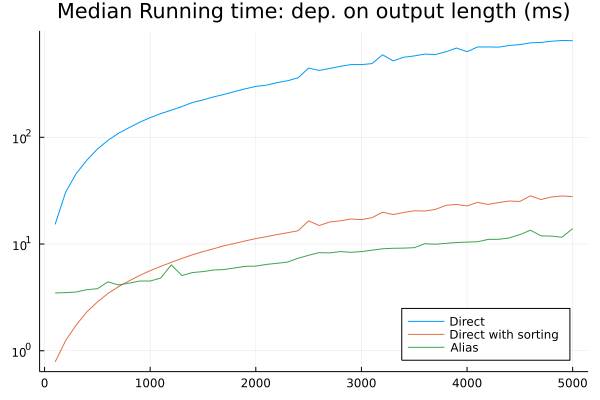

In [28]:
###Plot results
plot(s_step_o .* (1:E_o), [d_time_o ds_time_o da_time_o] ./ 10000,
     labels = ["Direct" "Direct with sorting" "Alias"],
     legend = :bottomright,
     title = "Median Running time: dep. on output length (ms)" , ##Time unit is probably wrong     yaxis = :log
     )

The sampling method with sorting is always faster than the direct method, and is faster than the alias method for N << K. We confirm this by benchmarking the methods by vaying K.

## Dependence on sampled vector length K

Compare execution time of direct_sample_sort! with direct_sample! and alias_sample! over increasing sampled vector length.
Tested sampled vector lengths: range 500:500:15_000.

In [8]:
###on basis of output length=1000
res = Array{Float64, 1}(undef, 1000); 

###To store execution time
E_s = 50;
d_time_s = Array{Float64, 1}(undef, E);
ds_time_s = Array{Float64, 1}(undef, E);
da_time_s = Array{Float64, 1}(undef, E);

s_step_s = 500;

for ex=1:E_s
    ###Sampled vector
    spl = collect(1:1.0:(s_step_s*ex));
    ###Random weights
    wts = rand(s_step_s*ex)
    ###Choose seed so that samplings are comparable
    sd = rand(1:10000)
    ###Sample with direct_sample
    b = @benchmark direct_sample!($(MersenneTwister(sd)), $spl, Weights($wts), $res) samples = 500 ÷ ex ##Otherwise takes too much time
    d_time_s[ex] = median(b).time
    ###Sample with direct sample with sorting
    b = @benchmark direct_sample_sort!($(MersenneTwister(sd)), $spl, Weights($wts), $res) samples = 500 ÷ ex ##Otherwise takes too much time
    ds_time_s[ex] = median(b).time
    ###Sample using alias sample
    b = @benchmark alias_sample!($(MersenneTwister(sd)), $spl, Weights($wts), $res) samples = 500 ÷ ex ##Otherwise takes too much time
    da_time_s[ex] = median(b).time
end

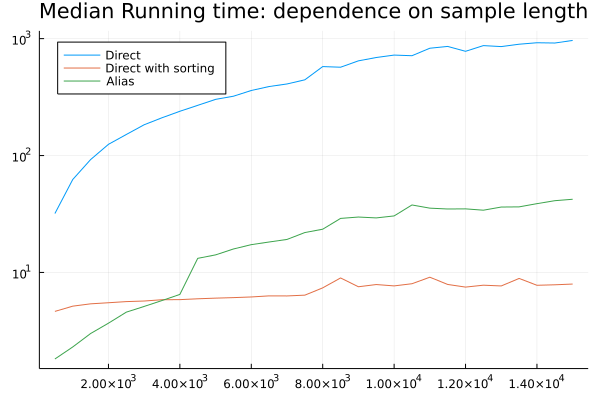

In [29]:
### Show results
plot(s_step_s .* (1:E), [d_time_s ds_time_s da_time_s] ./ 10000,
    labels = ["Direct" "Direct with sorting" "Alias"],
    legend = :topleft,
    title = "Median Running time: dependence on sample length",
    yaxis = :log)

This confirms the previous analysis, in particular the direct sampling with sorting is faster than the alias method when N << K.